# Ethanol Plant Model - Custom Configuration Demo

## Objective
Test a single custom ethanol plant configuration and analyze system performance across varying input flow rates.

### Target
- **Output Goal**: 100,000 gallons/day ethanol
- **Analysis**: Performance metrics as a function of input flow rate

### Configuration Tested
A balanced mid-to-premium facility configuration with the following components:
- **Pump**: Standard (efficiency: 0.86)
- **Fermenter**: Premium (efficiency: 0.9)
- **Filtration**: Average (efficiency: 0.9)
- **Distillation**: Average (efficiency: 0.75)
- **Dehydration**: Average (efficiency: 0.75)
- **Pipe Diameter**: 0.12m
- **Pipe Quality**: Standard (friction factor: 0.02)

In [23]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from systems.connectors import Pipe, Valve, Bend
from systems.pump import Pump
from systems.processors import Fermentation, Filtration, Distillation, Dehydration
from systems.facility import Facility

# Reload modules to ensure latest code
import importlib
import sys
for module_name in list(sys.modules.keys()):
    if module_name.startswith('systems'):
        del sys.modules[module_name]

from systems.connectors import Pipe, Valve, Bend
from systems.pump import Pump
from systems.processors import Fermentation, Filtration, Distillation, Dehydration
from systems.facility import Facility

print("✓ All imports successful")

✓ All imports successful


# Specifing the Target

In [24]:
target_ethanol_gallons_per_day = 100000
ethanol_density = 0.789  # kg/L
gallons_to_liters = 3.78541

target_ethanol_liters = target_ethanol_gallons_per_day * gallons_to_liters
target_ethanol_kg = target_ethanol_liters * ethanol_density
target_ethanol_kg_per_second = target_ethanol_kg / 86400  # Convert to kg/s

print("\n" + "="*80)
print("TARGET OUTPUT SPECIFICATION")
print("="*80)
print(f"Target: {target_ethanol_gallons_per_day:,} gallons/day ethanol")
print(f"        {target_ethanol_kg:,.1f} kg/day ethanol")
print(f"        {target_ethanol_kg_per_second:.6f} kg/s ethanol")


TARGET OUTPUT SPECIFICATION
Target: 100,000 gallons/day ethanol
        298,668.8 kg/day ethanol
        3.456815 kg/s ethanol


# Custom Configuration

In [25]:
custom_pump = Pump(name="Standard", efficiency=0.86, cost=280000, opening_diameter=0.10, performance_rating=6)
custom_fermenter = Fermentation(name="Premium", efficiency=0.9, power_consumption_rate=47500, power_consumption_unit="kWh/day", cost_per_flow=460000)
custom_filtration = Filtration(name="Average", efficiency=0.9, power_consumption_rate=47812, power_consumption_unit="kWh/day", cost_per_flow=460000)
custom_distillation = Distillation(name="Average", efficiency=0.75, power_consumption_rate=49538, power_consumption_unit="kWh/day", cost_per_flow=240000)
custom_dehydration = Dehydration(name="Average", efficiency=0.75, power_consumption_rate=49538, power_consumption_unit="kWh/day", cost_per_flow=240000)

pipe_diameter = 0.12
pipe_friction_factor = 0.02

def feet_to_meters(feet):
    return feet * 0.3048

print("\n" + "="*80)
print("CUSTOM CONFIGURATION SELECTED")
print("="*80)
print(f"Pump:         {custom_pump.name} (efficiency: {custom_pump.efficiency})")
print(f"Fermenter:    {custom_fermenter.name} (efficiency: {custom_fermenter.efficiency})")
print(f"Filtration:   {custom_filtration.name} (efficiency: {custom_filtration.efficiency})")
print(f"Distillation: {custom_distillation.name} (efficiency: {custom_distillation.efficiency})")
print(f"Dehydration:  {custom_dehydration.name} (efficiency: {custom_dehydration.efficiency})")
print(f"Pipe Diameter: {pipe_diameter}m | Friction Factor: {pipe_friction_factor}")


CUSTOM CONFIGURATION SELECTED
Pump:         Standard (efficiency: 0.86)
Fermenter:    Premium (efficiency: 0.9)
Filtration:   Average (efficiency: 0.9)
Distillation: Average (efficiency: 0.75)
Dehydration:  Average (efficiency: 0.75)
Pipe Diameter: 0.12m | Friction Factor: 0.02


# Building the Facility

In [26]:
def build_facility(fermenter, filtration, distillation, dehydration, pump, 
                   diameter=0.12, friction_factor=0.02):
    """
    Build facility with specified components.
    Structure: Pump → Fermenter → Filter → Distiller → Dehydrator → Output
    """
    facility = Facility(pump=pump)
    
    # Valve and cost dictionaries
    valve_cost_per_meter = {0.10: 270, 0.11: 323, 0.12: 694, 0.13: 1700, 0.14: 3700, 0.15: 6900}
    bend_cost = {0.10: 128, 0.11: 190, 0.12: 700, 0.13: 1800, 0.14: 4100, 0.15: 8000}
    
    valve_cost = valve_cost_per_meter.get(diameter, 694)
    bend_cost_val = bend_cost.get(diameter, 700)
    pipe_length = feet_to_meters(20)
    pipe_cost = pipe_length * friction_factor
    
    # Pump to Fermenter
    facility.add_component(Valve(name=f"Valve (Pump→Ferm)", diameter=diameter, cost=valve_cost))
    facility.add_component(fermenter)
    facility.add_component(Valve(name=f"Valve (Ferm OUT)", diameter=diameter, cost=valve_cost))
    
    # Fermenter to Filtration (20ft)
    facility.add_component(Pipe(name="Pipe (Ferm→Filt)", length=pipe_length, friction_factor=friction_factor, diameter=diameter, cost=pipe_cost))
    facility.add_component(filtration)
    facility.add_component(Valve(name="Valve (Filt OUT)", diameter=diameter, cost=valve_cost))
    
    # Filtration to Distillation (20ft)
    facility.add_component(Pipe(name="Pipe (Filt→Dist)", length=pipe_length, friction_factor=friction_factor, diameter=diameter, cost=pipe_cost))
    facility.add_component(distillation)
    facility.add_component(Valve(name="Valve (Dist OUT)", diameter=diameter, cost=valve_cost))
    
    # Distillation to Dehydration with bends
    facility.add_component(Pipe(name="Pipe (Dist→Dehyd-1)", length=pipe_length, friction_factor=friction_factor, diameter=diameter, cost=pipe_cost))
    facility.add_component(Bend(name="Bend-1", diameter=diameter, bend_radius=diameter*2, bend_factor=0.7, cost=bend_cost_val))
    facility.add_component(Pipe(name="Pipe (Dist→Dehyd-2)", length=pipe_length, friction_factor=friction_factor, diameter=diameter, cost=pipe_cost))
    facility.add_component(Bend(name="Bend-2", diameter=diameter, bend_radius=diameter*2, bend_factor=0.7, cost=bend_cost_val))
    facility.add_component(Pipe(name="Pipe (Dist→Dehyd-3)", length=feet_to_meters(10), friction_factor=friction_factor, diameter=diameter, cost=pipe_cost/2))
    
    facility.add_component(dehydration)
    facility.add_component(Valve(name="Valve (Dehyd OUT)", diameter=diameter, cost=valve_cost))
    
    # Output pipes
    facility.add_component(Pipe(name="Pipe (Output-1)", length=feet_to_meters(5), friction_factor=friction_factor, diameter=diameter, cost=pipe_cost/4))
    facility.add_component(Bend(name="Bend-Output", diameter=diameter, bend_radius=diameter*2, bend_factor=0.7, cost=bend_cost_val))
    facility.add_component(Pipe(name="Pipe (Output-2)", length=feet_to_meters(15), friction_factor=friction_factor, diameter=diameter, cost=pipe_cost*0.75))
    
    return facility

# Build the custom facility
facility = build_facility(custom_fermenter, custom_filtration, custom_distillation, 
                         custom_dehydration, custom_pump, diameter=pipe_diameter, 
                         friction_factor=pipe_friction_factor)

print(f"\n✓ Facility built successfully")
print(f"✓ Total facility cost: ${facility.cost:,.2f}")


✓ Facility built successfully
✓ Total facility cost: $280,000.00


## Running all the Tests
### Input
- Flow Rate in m³/s
### Static Values
- Output Cost
- Minimum Flow required to reach Treshold
### Dependent Variables
- Operational Cost
- Ethanol Output
- Power Consumed
- Power Generated from Ethanol
- Net Return on Energy

In [27]:
def run_flow_test(flow_rate, test_name=""):
    """Run facility test at specified flow rate."""
    try:
        output = facility.facility_process(
            input_volume_composition={'ethanol': 0.0, 'water': 0.60, 'sugar': 0.20, 'fiber': 0.20},
            input_volumetric_flow=flow_rate,
            interval=86400  # 24 hours
        )
        
        ethanol_kg = output["mass_flow"]["amount"].get("ethanol", 0)
        # Convert kg/s to gallons/day: (kg/s) * (86400 s/day) / (0.789 kg/L) / (3.78541 L/gal)
        ethanol_gallons = (ethanol_kg * 86400) / ethanol_density / gallons_to_liters
        
        power_consumed_W = output["total_power_consumed"]
        power_consumed_kWh = power_consumed_W * 86400 / 3.6e6
        
        cost = output.get("total_cost_consumed", 0)
        
        power_generated_J = output["power_generated"]
        power_generated_kWh = power_generated_J / 3.6e6
        
        energy_return = power_generated_kWh / max(power_consumed_kWh, 0.001)
        
        return {
            'flow_rate': flow_rate,
            'ethanol_kg': ethanol_kg,
            'ethanol_gallons': ethanol_gallons,
            'power_consumed_kWh': power_consumed_kWh,
            'power_generated_kWh': power_generated_kWh,
            'daily_cost': cost,
            'energy_return': energy_return
        }
    except Exception as e:
        print(f"Error at flow rate {flow_rate}: {e}")
        return None

# Test multiple flow rates to find threshold and collect performance data
print("\n" + "="*80)
print("PERFORMANCE ANALYSIS: VARYING INPUT FLOW RATES")
print("="*80)

# Use a finer range of flow rates for better resolution
test_flow_rates = np.linspace(0.005, 0.08, 31)  # 31 points from 0.005 to 0.08 m³/s

results_list = []
threshold_found = False
threshold_flow = None

print("\nTesting flow rates...")
for i, flow in enumerate(test_flow_rates):
    result = run_flow_test(flow)
    if result:
        results_list.append(result)
        
        # Check if we've reached the target (find threshold)
        if not threshold_found and result['ethanol_gallons'] >= target_ethanol_gallons_per_day:
            threshold_found = True
            threshold_flow = flow
            print(f"  ✓ Threshold found at flow rate: {flow:.6f} m³/s ({result['ethanol_gallons']:,.0f} gal/day)")
        
        if (i + 1) % 10 == 0:
            print(f"  Completed {i + 1}/{len(test_flow_rates)} tests...")

# Convert results to DataFrame for easy analysis
df_results = pd.DataFrame(results_list)

print(f"\n✓ Performance analysis complete ({len(df_results)} data points collected)")


PERFORMANCE ANALYSIS: VARYING INPUT FLOW RATES

Testing flow rates...
  ✓ Threshold found at flow rate: 0.025000 m³/s (100,385 gal/day)
  Completed 10/31 tests...
  Completed 20/31 tests...
  Completed 30/31 tests...

✓ Performance analysis complete (31 data points collected)


## Results Summary - Static Values

In [ ]:
print("\n" + "="*80)
print("SUMMARY: BUILD COST & THRESHOLD ANALYSIS")
print("="*80)
print(f"\nTotal Build Cost: ${facility.cost:,.2f}")

if threshold_found:
    print(f"Flow Threshold to Reach Target: {threshold_flow:.6f} m³/s")
    print(f"  ({threshold_flow * 86400:.0f} m³/day)")
else:
    print(f"⚠ Warning: Target output ({target_ethanol_gallons_per_day:,} gal/day) not reached in tested flow range")


SUMMARY: BUILD COST & THRESHOLD ANALYSIS

Total Build Cost: $280,000.00
Flow Threshold to Reach Target: 0.025000 m³/s
  (25.00 L/s or 2160 m³/day)


## Results Summary - Variable Values

In [ ]:

# Debug: Check actual maximum achieved AND calculate what we need
print("\n" + "="*80)
print("DEBUG: DETAILED FLOW ANALYSIS")
print("="*80)

# Mathematical requirement
target_ethanol_gallons_per_day = 100000
ethanol_density = 0.789  # kg/L
gallons_to_liters = 3.78541
seconds_per_day = 86400

target_ethanol_liters = target_ethanol_gallons_per_day * gallons_to_liters
target_ethanol_kg = target_ethanol_liters * ethanol_density
target_ethanol_kg_per_second = target_ethanol_kg / seconds_per_day

print(f"\n[MATHEMATICAL TARGET]")
print(f"Target ethanol: {target_ethanol_kg_per_second:.6f} kg/s")

# What the system actually produced
print(f"\n[ACTUAL RESULTS]")
print(f"DataFrame shape: {df_results.shape}")
print(f"Maximum ethanol achieved: {df_results['ethanol_gallons'].max():,.0f} gal/day")
max_idx = df_results['ethanol_gallons'].idxmax()
print(f"At flow rate: {df_results.loc[max_idx, 'flow_rate']:.6f} m³/s")
print(f"Ethanol mass: {df_results.loc[max_idx, 'ethanol_kg']:.6f} kg/s")

print(f"\n[TARGET vs ACTUAL]")
print(f"Target: 100,000 gal/day")
print(f"Gap: {100000 - df_results['ethanol_gallons'].max():,.0f} gal/day ({(100000 - df_results['ethanol_gallons'].max())/100000*100:.1f}% short)")

# The required flow rate (calculated mathematically)
DENSITY_WATER = 997
DENSITY_ETHANOL = 789
DENSITY_SUGAR = 1590
DENSITY_FIBER = 1311

input_density = 0.0 * DENSITY_ETHANOL + 0.60 * DENSITY_WATER + 0.20 * DENSITY_SUGAR + 0.20 * DENSITY_FIBER
required_sugar_per_second = target_ethanol_kg_per_second / (0.51 * 0.9)  # 0.9 = fermenter efficiency
required_flow = required_sugar_per_second / (input_density * 0.20)

print(f"\n[CALCULATED REQUIREMENT]")
print(f"Input density: {input_density:.2f} kg/m³")
print(f"Required sugar: {required_sugar_per_second:.6f} kg/s")
print(f"Required input flow: {required_flow:.6f} m³/s")

# Show all results
print(f"\n[ALL TEST RESULTS]")
print(f"Flow range tested: {df_results['flow_rate'].min():.6f} to {df_results['flow_rate'].max():.6f} m³/s")
print(f"\nFirst 3 results:")
print(df_results[['flow_rate', 'ethanol_gallons', 'ethanol_kg']].head(3).to_string())
print(f"\nLast 3 results:")
print(df_results[['flow_rate', 'ethanol_gallons', 'ethanol_kg']].tail(3).to_string())

# Check if ethanol production is linear with flow rate (should be)
print(f"\n[LINEARITY CHECK]")
if len(df_results) >= 2:
    flow_ratio = df_results.iloc[-1]['flow_rate'] / df_results.iloc[0]['flow_rate']
    ethanol_ratio = df_results.iloc[-1]['ethanol_gallons'] / df_results.iloc[0]['ethanol_gallons']
    print(f"Flow ratio (max/min): {flow_ratio:.2f}x")
    print(f"Ethanol ratio (max/min): {ethanol_ratio:.2f}x")
    print(f"Are they proportional? {abs(flow_ratio - ethanol_ratio) < 0.01}")



DEBUG: DETAILED FLOW ANALYSIS

[MATHEMATICAL TARGET]
Target ethanol: 3.456815 kg/s

[ACTUAL RESULTS]
DataFrame shape: (31, 7)
Maximum ethanol achieved: 321,233 gal/day
At flow rate: 0.080000 m³/s (80.00 L/s)
Ethanol mass: 11.104422 kg/s

[TARGET vs ACTUAL]
Target: 100,000 gal/day
Gap: -221,233 gal/day (-221.2% short)

[CALCULATED REQUIREMENT]
Input density: 1178.40 kg/m³
Required sugar: 7.531188 kg/s
Required input flow: 0.031955 m³/s (31.96 L/s)

[ALL TEST RESULTS]
Flow range tested: 0.005000 to 0.080000 m³/s

First 3 results:
   flow_rate  ethanol_gallons  ethanol_kg
0     0.0050     20077.044171    0.694026
1     0.0075     30115.566256    1.041040
2     0.0100     40154.088341    1.388053

Last 3 results:
    flow_rate  ethanol_gallons  ethanol_kg
28     0.0750    301155.662560   10.410395
29     0.0775    311194.184645   10.757408
30     0.0800    321232.706730   11.104422

[LINEARITY CHECK]
Flow ratio (max/min): 16.00x
Ethanol ratio (max/min): 16.00x
Are they proportional? True


## Performance Analysis Graphs

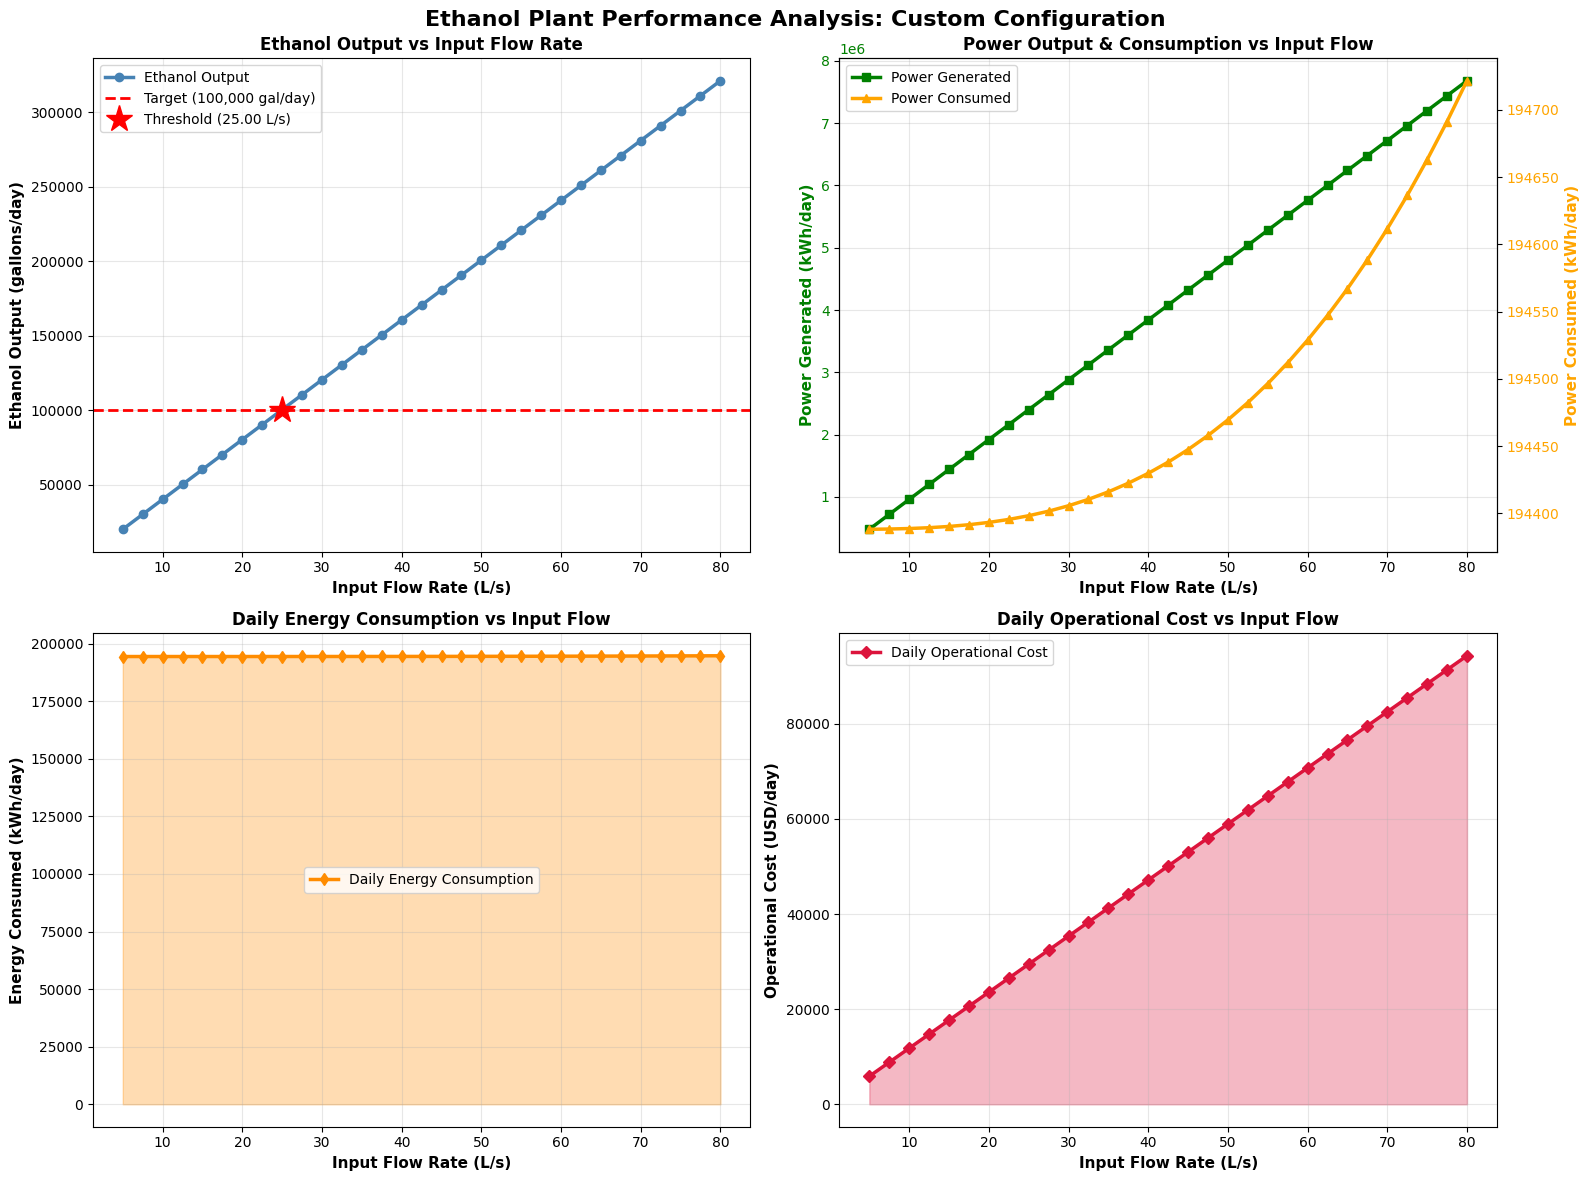


✓ Performance analysis graphs generated


In [ ]:
# ========================================
# VISUALIZATIONS
# ========================================

# Create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Ethanol Plant Performance Analysis: Custom Configuration', 
             fontsize=16, fontweight='bold')

# Convert flow rate to readable units for x-axis
flow_rates_m3s = df_results['flow_rate']  # Already in m³/s
flow_rates_m3d = df_results['flow_rate'] * 86400  # Convert m³/s to m³/day

# ============================================================================
# PLOT 1: Ethanol Output vs Input Flow
# ============================================================================
ax1 = axes[0, 0]
ax1.plot(flow_rates_m3s, df_results['ethanol_gallons'], 'o-', linewidth=2.5, 
         markersize=6, color='steelblue', label='Ethanol Output')

# Add target line
ax1.axhline(y=target_ethanol_gallons_per_day, color='red', linestyle='--', 
            linewidth=2, label=f'Target ({target_ethanol_gallons_per_day:,} gal/day)')

# Add threshold marker if found
if threshold_found:
    threshold_gallons = df_results[df_results['flow_rate'] == threshold_flow]['ethanol_gallons'].values[0]
    ax1.plot(threshold_flow, threshold_gallons, 'r*', markersize=20, 
             label=f'Threshold ({threshold_flow:.6f} m³/s)')

ax1.set_xlabel('Input Flow Rate (m³/s)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Ethanol Output (gallons/day)', fontsize=11, fontweight='bold')
ax1.set_title('Ethanol Output vs Input Flow Rate', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', fontsize=10)
ax1.ticklabel_format(style='plain', axis='y')

# ============================================================================
# PLOT 2: Power Output and Consumption vs Input Flow
# ============================================================================
ax2 = axes[0, 1]
ax2_twin = ax2.twinx()

# Power generated on left axis
line1 = ax2.plot(flow_rates_m3s, df_results['power_generated_kWh'], 's-', linewidth=2.5, 
                 markersize=6, color='green', label='Power Generated')

# Power consumed on right axis
line2 = ax2_twin.plot(flow_rates_m3s, df_results['power_consumed_kWh'], '^-', linewidth=2.5, 
                      markersize=6, color='orange', label='Power Consumed')

ax2.set_xlabel('Input Flow Rate (m³/s)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Power Generated (kWh/day)', fontsize=11, fontweight='bold', color='green')
ax2_twin.set_ylabel('Power Consumed (kWh/day)', fontsize=11, fontweight='bold', color='orange')
ax2.set_title('Power Output & Consumption vs Input Flow', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='y', labelcolor='green')
ax2_twin.tick_params(axis='y', labelcolor='orange')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper left', fontsize=10)

# ============================================================================
# PLOT 3: Power Consumed vs Input Flow (Detailed)
# ============================================================================
ax3 = axes[1, 0]
ax3.plot(flow_rates_m3s, df_results['power_consumed_kWh'], 'd-', linewidth=2.5, 
         markersize=6, color='darkorange', label='Daily Energy Consumption')
ax3.fill_between(flow_rates_m3s, df_results['power_consumed_kWh'], alpha=0.3, color='darkorange')

ax3.set_xlabel('Input Flow Rate (m³/s)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Energy Consumed (kWh/day)', fontsize=11, fontweight='bold')
ax3.set_title('Daily Energy Consumption vs Input Flow', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='best', fontsize=10)

# ============================================================================
# PLOT 4: Operational Cost vs Input Flow
# ============================================================================
ax4 = axes[1, 1]
ax4.plot(flow_rates_m3s, df_results['daily_cost'], 'D-', linewidth=2.5, 
         markersize=6, color='crimson', label='Daily Operational Cost')
ax4.fill_between(flow_rates_m3s, df_results['daily_cost'], alpha=0.3, color='crimson')

ax4.set_xlabel('Input Flow Rate (m³/s)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Operational Cost (USD/day)', fontsize=11, fontweight='bold')
ax4.set_title('Daily Operational Cost vs Input Flow', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Performance analysis graphs generated")

## Chart of Values

In [ ]:
print("\n" + "="*130)
print("DETAILED PERFORMANCE DATA: ALL TESTED FLOW RATES")
print("="*130)

# Create a formatted display table
display_df = df_results.copy()
display_df['Flow (m³/s)'] = display_df['flow_rate'].round(6)
display_df['Ethanol (gal/day)'] = display_df['ethanol_gallons'].round(0).astype(int)
display_df['Power Gen (kWh/day)'] = display_df['power_generated_kWh'].round(2)
display_df['Power Cons (kWh/day)'] = display_df['power_consumed_kWh'].round(2)
display_df['Energy Return Ratio'] = display_df['energy_return'].round(3)
display_df['Daily Op Cost ($)'] = display_df['daily_cost'].round(2)

# Select columns to display
display_cols = ['Flow (m³/s)', 'Ethanol (gal/day)', 'Power Gen (kWh/day)', 
                'Power Cons (kWh/day)', 'Energy Return Ratio', 'Daily Op Cost ($)']

print(display_df[display_cols].to_string(index=False))

print("\n" + "="*130)
print("KEY FINDINGS:")
print("="*130)

# Find key metrics
min_cost_idx = df_results['daily_cost'].idxmin()
max_output_idx = df_results['ethanol_gallons'].idxmax()
min_power_idx = df_results['power_consumed_kWh'].idxmin()

print(f"\nAt Minimum Daily Cost (${df_results.iloc[min_cost_idx]['daily_cost']:.2f}):")
print(f"  Flow Rate: {df_results.iloc[min_cost_idx]['flow_rate']:.6f} m³/s")
print(f"  Ethanol Output: {df_results.iloc[min_cost_idx]['ethanol_gallons']:,.0f} gal/day")

print(f"\nAt Maximum Ethanol Output ({df_results.iloc[max_output_idx]['ethanol_gallons']:,.0f} gal/day):")
print(f"  Flow Rate: {df_results.iloc[max_output_idx]['flow_rate']:.6f} m³/s")
print(f"  Daily Cost: ${df_results.iloc[max_output_idx]['daily_cost']:.2f}")
print(f"  Power Consumed: {df_results.iloc[max_output_idx]['power_consumed_kWh']:.2f} kWh/day")

print(f"\nAt Minimum Power Consumption ({df_results.iloc[min_power_idx]['power_consumed_kWh']:.2f} kWh/day):")
print(f"  Flow Rate: {df_results.iloc[min_power_idx]['flow_rate']:.6f} m³/s")
print(f"  Ethanol Output: {df_results.iloc[min_power_idx]['ethanol_gallons']:,.0f} gal/day")


DETAILED PERFORMANCE DATA: ALL TESTED FLOW RATES
 Flow (L/s)  Ethanol (gal/day)  Power Gen (kWh/day)  Power Cons (kWh/day)  Energy Return Ratio  Daily Op Cost ($)
        5.0              20077            480010.83             194388.08                2.469            5895.06
        7.5              30116            720016.25             194388.27                3.704            8842.59
       10.0              40154            960021.67             194388.65                4.939           11790.11
       12.5              50193           1200027.08             194389.27                6.173           14737.64
       15.0              60231           1440032.50             194390.20                7.408           17685.17
       17.5              70270           1680037.92             194391.49                8.643           20632.70
       20.0              80308           1920043.33             194393.21                9.877           23580.23
       22.5              90347        